In [1]:
import os
import zipfile
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


**Load nucleolar protein data**

In [2]:
data = pd.read_csv('results/reviewed_and_longest_proteins/nucleolar_proteins.tsv', sep='\t')
data

,Majority.protein.IDs,Reviewed,Protein ID,Sequence,Label,Parsed_Domains,length,pI
0,P08775,reviewed,P08775,MHGGGPPSGDSACPLRTIKRVQFGVLSPDELKRMSVTEGGIKYPET...,S47,NaN,1970,7.015489
1,P02468,reviewed,P02468,MTGGGRAALALQPRGRLWPLLAVLAAVAGCVRAAMDECADEGGRPQ...,S47,"['Laminin N-terminal', 'Laminin EGF-like 1', '...",1607,5.083475
2,O88322,reviewed,O88322,MFRDPTAGWLTPPSPLSLLVMLLLLSRVGALRPDELFPYGESWGDQ...,S47,"['NIDO', 'EGF-like 1', 'Nidogen G2 beta-barrel...",1403,5.161344
3,P23116,reviewed,P23116,MPAYFQRPENALKRANEFLEVGKKQPALDVLYDVMKSKKHRTWQKI...,S47,['PCI'],1344,6.377983
4,Q9CU62,reviewed,Q9CU62,MGFLKLIEIENFKSYKGRQIIGPFQRFTAIIGPNGSGKSNLMDAIS...,S45,['SMC hinge'],1233,7.510329
...,...,...,...,...,...,...,...,...
272,Q99LT0,reviewed,Q99LT0,MESEQMLEGQTQVAENPHSEYGLTDSVERIVENEKINAEKSSKQKV...,S45,NaN,99,4.840829
273,O35900,reviewed,O35900,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVT...,ITS2,['Sm'],95,6.047464
274,P61514,reviewed,P61514,MAKRTKKVGIVGKYGTRYGASLRKMVKKIEISQHAKYTCSFCGKTK...,S45,NaN,92,10.441509
275,O54962,reviewed,O54962,MTTSQKHRDFVAEPMGEKPVGSLAGIGDVLSKRLEERGFDKAYVVL...,ITS2,['HhH'],89,5.790722


**Parse NARDINI output zip files and rename**

In [ ]:
def parse_zipped_nardini_files(DATA_DIR):

    all_rows = []

    for fname in os.listdir(DATA_DIR):
        print(f"Processing {fname}")
        if fname.endswith(".zip") and fname.startswith("nardini-data-"):
            zip_path = os.path.join(DATA_DIR, fname)

            tmp_extract_dir = os.path.join(DATA_DIR, "temp_extract")
            if not os.path.exists(tmp_extract_dir):
                os.makedirs(tmp_extract_dir)
                print(f"Created temp dir: {tmp_extract_dir}")

            with zipfile.ZipFile(zip_path, "r") as zip_ref:
                zip_ref.extractall(tmp_extract_dir)
                print(f"Extracted {zip_path} to {tmp_extract_dir}")
            
            seq_file = os.path.join(tmp_extract_dir, "sequences.tsv")
            zscore_original_file = os.path.join(tmp_extract_dir, "zscore-original-sequence-seq1.tsv")
            
            sequences_df = pd.read_csv(seq_file, sep=r"\s+")

            zscore_original_df = pd.read_csv(zscore_original_file, sep=r"\s+")
            columns_list = zscore_original_df.columns.tolist()

            matrix_values = {}
            for row_label in range(len(zscore_original_df)):
                for col_label in columns_list:

                    label1 = rename_dict[columns_list[row_label]].lower()
                    label2 = rename_dict[col_label].lower()
                    colname = f"block {label1}" if label1 == label2 else f"block {label1}-{label2}"
                    matrix_values[colname] = zscore_original_df.loc[row_label, col_label]
            
            for _, seq_row in sequences_df.iterrows():
                row_dict = {}

                row_dict["original_seq"] = seq_row["original_seq"]
                
                row_dict.update(matrix_values)
                
                all_rows.append(row_dict)
            
            shutil.rmtree(tmp_extract_dir)

    final_df = pd.DataFrame(all_rows)

    return final_df

rename_dict = { "µ": "POLAR", "h": "HYDROPHOBIC", "+": "POSITIVE", "-": "NEGATIVE", "π": "AROMATIC", "A": "ALANINE", "P": "PROLINE", "G": "GLYCINE" }

DATA_DIR = "analysis/nardini/zip_files"
compartments = parse_zipped_nardini_files(DATA_DIR)

**Combine with original dataframe**

In [4]:
data["Sequence"] = data["Sequence"].apply(lambda x: x.replace("U", "C"))
data_with_zscores = pd.merge(data, compartments, left_on='Sequence', right_on='original_seq', how='left')
zscore_columns = [col for col in data_with_zscores.columns if col.startswith("block")]
data_with_zscores

,Majority.protein.IDs,Reviewed,Protein ID,Sequence,Label,Parsed_Domains,length,pI,original_seq,block polar,...,block proline,block proline-glycine,block glycine-polar,block glycine-hydrophobic,block glycine-positive,block glycine-negative,block glycine-aromatic,block glycine-alanine,block glycine-proline,block glycine
0,P08775,reviewed,P08775,MHGGGPPSGDSACPLRTIKRVQFGVLSPDELKRMSVTEGGIKYPET...,S47,NaN,1970,7.015489,MHGGGPPSGDSACPLRTIKRVQFGVLSPDELKRMSVTEGGIKYPET...,1.373720,...,3.34406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P02468,reviewed,P02468,MTGGGRAALALQPRGRLWPLLAVLAAVAGCVRAAMDECADEGGRPQ...,S47,"['Laminin N-terminal', 'Laminin EGF-like 1', '...",1607,5.083475,MTGGGRAALALQPRGRLWPLLAVLAAVAGCVRAAMDECADEGGRPQ...,1.215010,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O88322,reviewed,O88322,MFRDPTAGWLTPPSPLSLLVMLLLLSRVGALRPDELFPYGESWGDQ...,S47,"['NIDO', 'EGF-like 1', 'Nidogen G2 beta-barrel...",1403,5.161344,MFRDPTAGWLTPPSPLSLLVMLLLLSRVGALRPDELFPYGESWGDQ...,0.696268,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P23116,reviewed,P23116,MPAYFQRPENALKRANEFLEVGKKQPALDVLYDVMKSKKHRTWQKI...,S47,['PCI'],1344,6.377983,MPAYFQRPENALKRANEFLEVGKKQPALDVLYDVMKSKKHRTWQKI...,3.174190,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Q9CU62,reviewed,Q9CU62,MGFLKLIEIENFKSYKGRQIIGPFQRFTAIIGPNGSGKSNLMDAIS...,S45,['SMC hinge'],1233,7.510329,MGFLKLIEIENFKSYKGRQIIGPFQRFTAIIGPNGSGKSNLMDAIS...,0.463383,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,Q99LT0,reviewed,Q99LT0,MESEQMLEGQTQVAENPHSEYGLTDSVERIVENEKINAEKSSKQKV...,S45,NaN,99,4.840829,MESEQMLEGQTQVAENPHSEYGLTDSVERIVENEKINAEKSSKQKV...,-1.329210,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273,O35900,reviewed,O35900,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVT...,ITS2,['Sm'],95,6.047464,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVT...,-0.494184,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,P61514,reviewed,P61514,MAKRTKKVGIVGKYGTRYGASLRKMVKKIEISQHAKYTCSFCGKTK...,S45,NaN,92,10.441509,MAKRTKKVGIVGKYGTRYGASLRKMVKKIEISQHAKYTCSFCGKTK...,1.457900,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275,O54962,reviewed,O54962,MTTSQKHRDFVAEPMGEKPVGSLAGIGDVLSKRLEERGFDKAYVVL...,ITS2,['HhH'],89,5.790722,MTTSQKHRDFVAEPMGEKPVGSLAGIGDVLSKRLEERGFDKAYVVL...,1.387220,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Plot clustermap**

/tmp/ipykernel_2415081/2334912379.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stars = pvals.applymap(p_to_star)


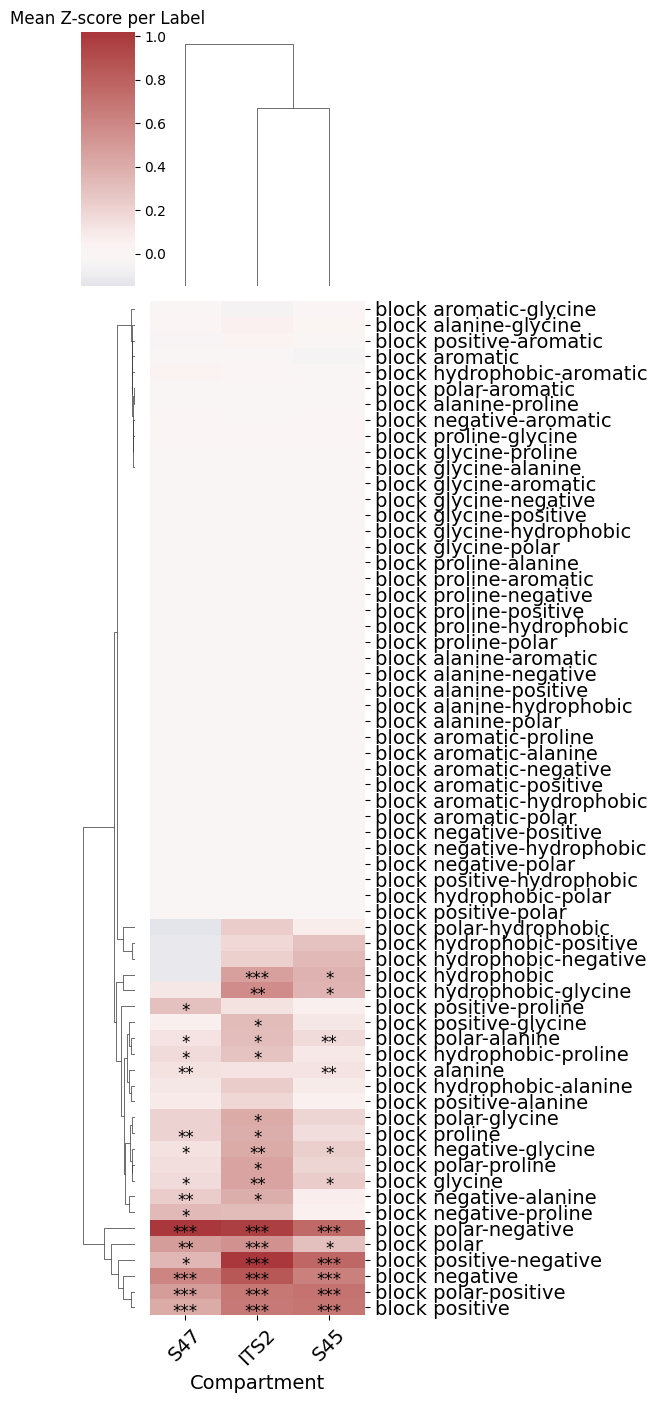

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

def p_to_star(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

def plot_zsc_heatmap(df):
    zsc_cols = [c for c in df.columns if c.startswith("block")]

    mean_df = df.groupby("Label")[zsc_cols].mean()

    pvals = df.groupby("Label")[zsc_cols].apply(
        lambda x: ttest_1samp(x, 0, axis=0, nan_policy="omit").pvalue
    )

    pvals = pd.DataFrame(
        np.vstack(pvals.values),
        index=pvals.index,
        columns=zsc_cols
    )

    stars = pvals.applymap(p_to_star)

    g = sns.clustermap(
        mean_df.T,
        cmap="vlag",
        center=0,
        xticklabels=True,
        yticklabels=True,
        figsize=(6, 14)
    )

    ax = g.ax_heatmap

    plot_data = g.data2d

    stars_plot = stars.T.reindex(
        index=plot_data.index,
        columns=plot_data.columns
    )

    for y in range(plot_data.shape[0]):    
        for x in range(plot_data.shape[1]):  
            star = stars_plot.iloc[y, x]
            if star:
                ax.text(
                    x + 0.5, y + 0.8, star,
                    ha="center", va="center",
                    fontsize=12, color="black"
                )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)
    ax.set_xlabel("Compartment", fontsize=14)
    ax.set_ylabel("")

    plt.title("Mean Z-score per Label")
    plt.tight_layout()
    plt.savefig(
        "analysis/revision/results/mean_zscore_per_label.svg",
        bbox_inches="tight"
    )
    plt.show()

plot_zsc_heatmap(data_with_zscores)